In [1]:
from sklearn import model_selection
from sklearn import metrics
import os
import numpy as np
import pandas as pd
from MicroBiome import MicroBiomeDataSet, Trainer, TrainTester, MultiTrainTester
from sklearn import linear_model as LM
import seaborn as sns

# Ignore warning messages
if True:
    import warnings
    warnings.filterwarnings('ignore')

# Load Data

In [2]:
top_dir = '/project'
data_dir = os.path.join(top_dir, 'data')
preproc_dir = os.path.join(data_dir, 'preprocessed')
inp_dir = os.path.join(preproc_dir, 'Gupta_2020_Precompiled_Cleaned')

In [3]:
os.listdir(inp_dir)

['MatrixDataClean.csv', 'SampleMetaDataClean.csv', 'FeatMetaDataClean.csv']

In [4]:
MatrixData = np.loadtxt(os.path.join(inp_dir, 'MatrixDataClean.csv'))
MatrixData.shape

(4347, 903)

In [5]:
SampleMeta = pd.read_csv(os.path.join(inp_dir, 'SampleMetaDataClean.csv'))
SampleMeta.shape

(4347, 34)

In [6]:
filter_indices = SampleMeta["Phenotype"].isin(['CRC', 'Healthy'])
SampleMeta = SampleMeta[ filter_indices ]
SampleMeta.shape

(2893, 34)

In [7]:
MatrixData = MatrixData[ filter_indices ]
MatrixData.shape

(2893, 903)

In [8]:
FeatMeta = pd.read_csv(os.path.join(inp_dir, 'FeatMetaDataClean.csv'))
FeatMeta

,Unnamed: 0,feature
0,s__Abiotrophia_defectiva,s__Abiotrophia_defectiva
1,s__Acetobacter_unclassified,s__Acetobacter_unclassified
2,s__Achromobacter_piechaudii,s__Achromobacter_piechaudii
3,s__Achromobacter_unclassified,s__Achromobacter_unclassified
4,s__Achromobacter_xylosoxidans,s__Achromobacter_xylosoxidans
...,...,...
898,s__Weissella_koreensis,s__Weissella_koreensis
899,s__Weissella_paramesenteroides,s__Weissella_paramesenteroides
900,s__Weissella_unclassified,s__Weissella_unclassified
901,s__Wohlfahrtiimonas_chitiniclastica,s__Wohlfahrtiimonas_chitiniclastica


# Define and Train Model

In [9]:
# random seed here deals with model initialization
MyLogistic = LM.LogisticRegressionCV(random_state = 42, class_weight='balanced', Cs = np.exp(-np.arange(-10, 10)),
                                     solver='saga', penalty='elasticnet', l1_ratios=np.arange(0, 1.25, 0.25))
MyTrainer = Trainer(model = MyLogistic, scale_X = True, use_pca = False)
# random seed used in class definition is not used in final output models
MyTrainTester = TrainTester(MyTrainer, metrics.balanced_accuracy_score)
# note that random seed here affects sequence of seeds passed to making new TrainTester objects
# using LRTrainTester as template. Thus, you have all settings but seed affecting sample split
# across all data splits
n_splits = 5
MyMultiTrainTester = MultiTrainTester(MyTrainTester, numpy_rand_seed = 42, n_splits = n_splits)

In [10]:
y = SampleMeta['Phenotype'].to_numpy() == 'Healthy'
y = y.astype('int64')

In [11]:
MyMultiTrainTester.train(MatrixData, y)

Running for split 1 of 5
Running for split 2 of 5
Running for split 3 of 5
Running for split 4 of 5
Running for split 5 of 5


In [12]:
scores_df = pd.DataFrame({'score': MyMultiTrainTester.train_scores, 'stage' : np.repeat('train', n_splits)})
scores_df = scores_df.append(pd.DataFrame({'score': MyMultiTrainTester.test_scores, 'stage' : np.repeat('test', n_splits)}))
scores_df

,score,stage
0,0.846687,train
1,0.785089,train
2,0.815292,train
3,0.814135,train
4,0.824626,train
0,0.728532,test
1,0.692004,test
2,0.752195,test
3,0.744101,test
4,0.748072,test


<AxesSubplot:xlabel='stage', ylabel='score'>

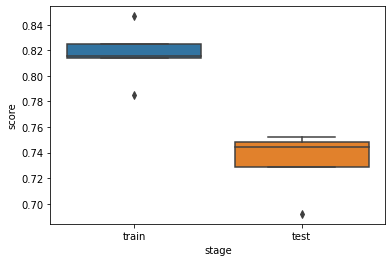

In [13]:
sns.boxplot(data = scores_df, x = 'stage', y = 'score')

In [14]:
MyMultiTrainTester.TrainerList[0].model.Cs_

array([2.20264658e+04, 8.10308393e+03, 2.98095799e+03, 1.09663316e+03,
       4.03428793e+02, 1.48413159e+02, 5.45981500e+01, 2.00855369e+01,
       7.38905610e+00, 2.71828183e+00, 1.00000000e+00, 3.67879441e-01,
       1.35335283e-01, 4.97870684e-02, 1.83156389e-02, 6.73794700e-03,
       2.47875218e-03, 9.11881966e-04, 3.35462628e-04, 1.23409804e-04])

In [15]:
hyperparams = {'l1_ratio': [], 'C': []}
for i in range(n_splits):
    hyperparams['l1_ratio'].append(MyMultiTrainTester.TrainerList[i].model.l1_ratio_)
    hyperparams['C'].append(MyMultiTrainTester.TrainerList[i].model.C_)

In [16]:
pd.DataFrame(hyperparams)

,l1_ratio,C
0,[0.0],[0.0009118819655545162]
1,[0.0],[0.00012340980408667956]
2,[0.0],[0.00012340980408667956]
3,[0.0],[0.00012340980408667956]
4,[0.0],[0.00033546262790251185]


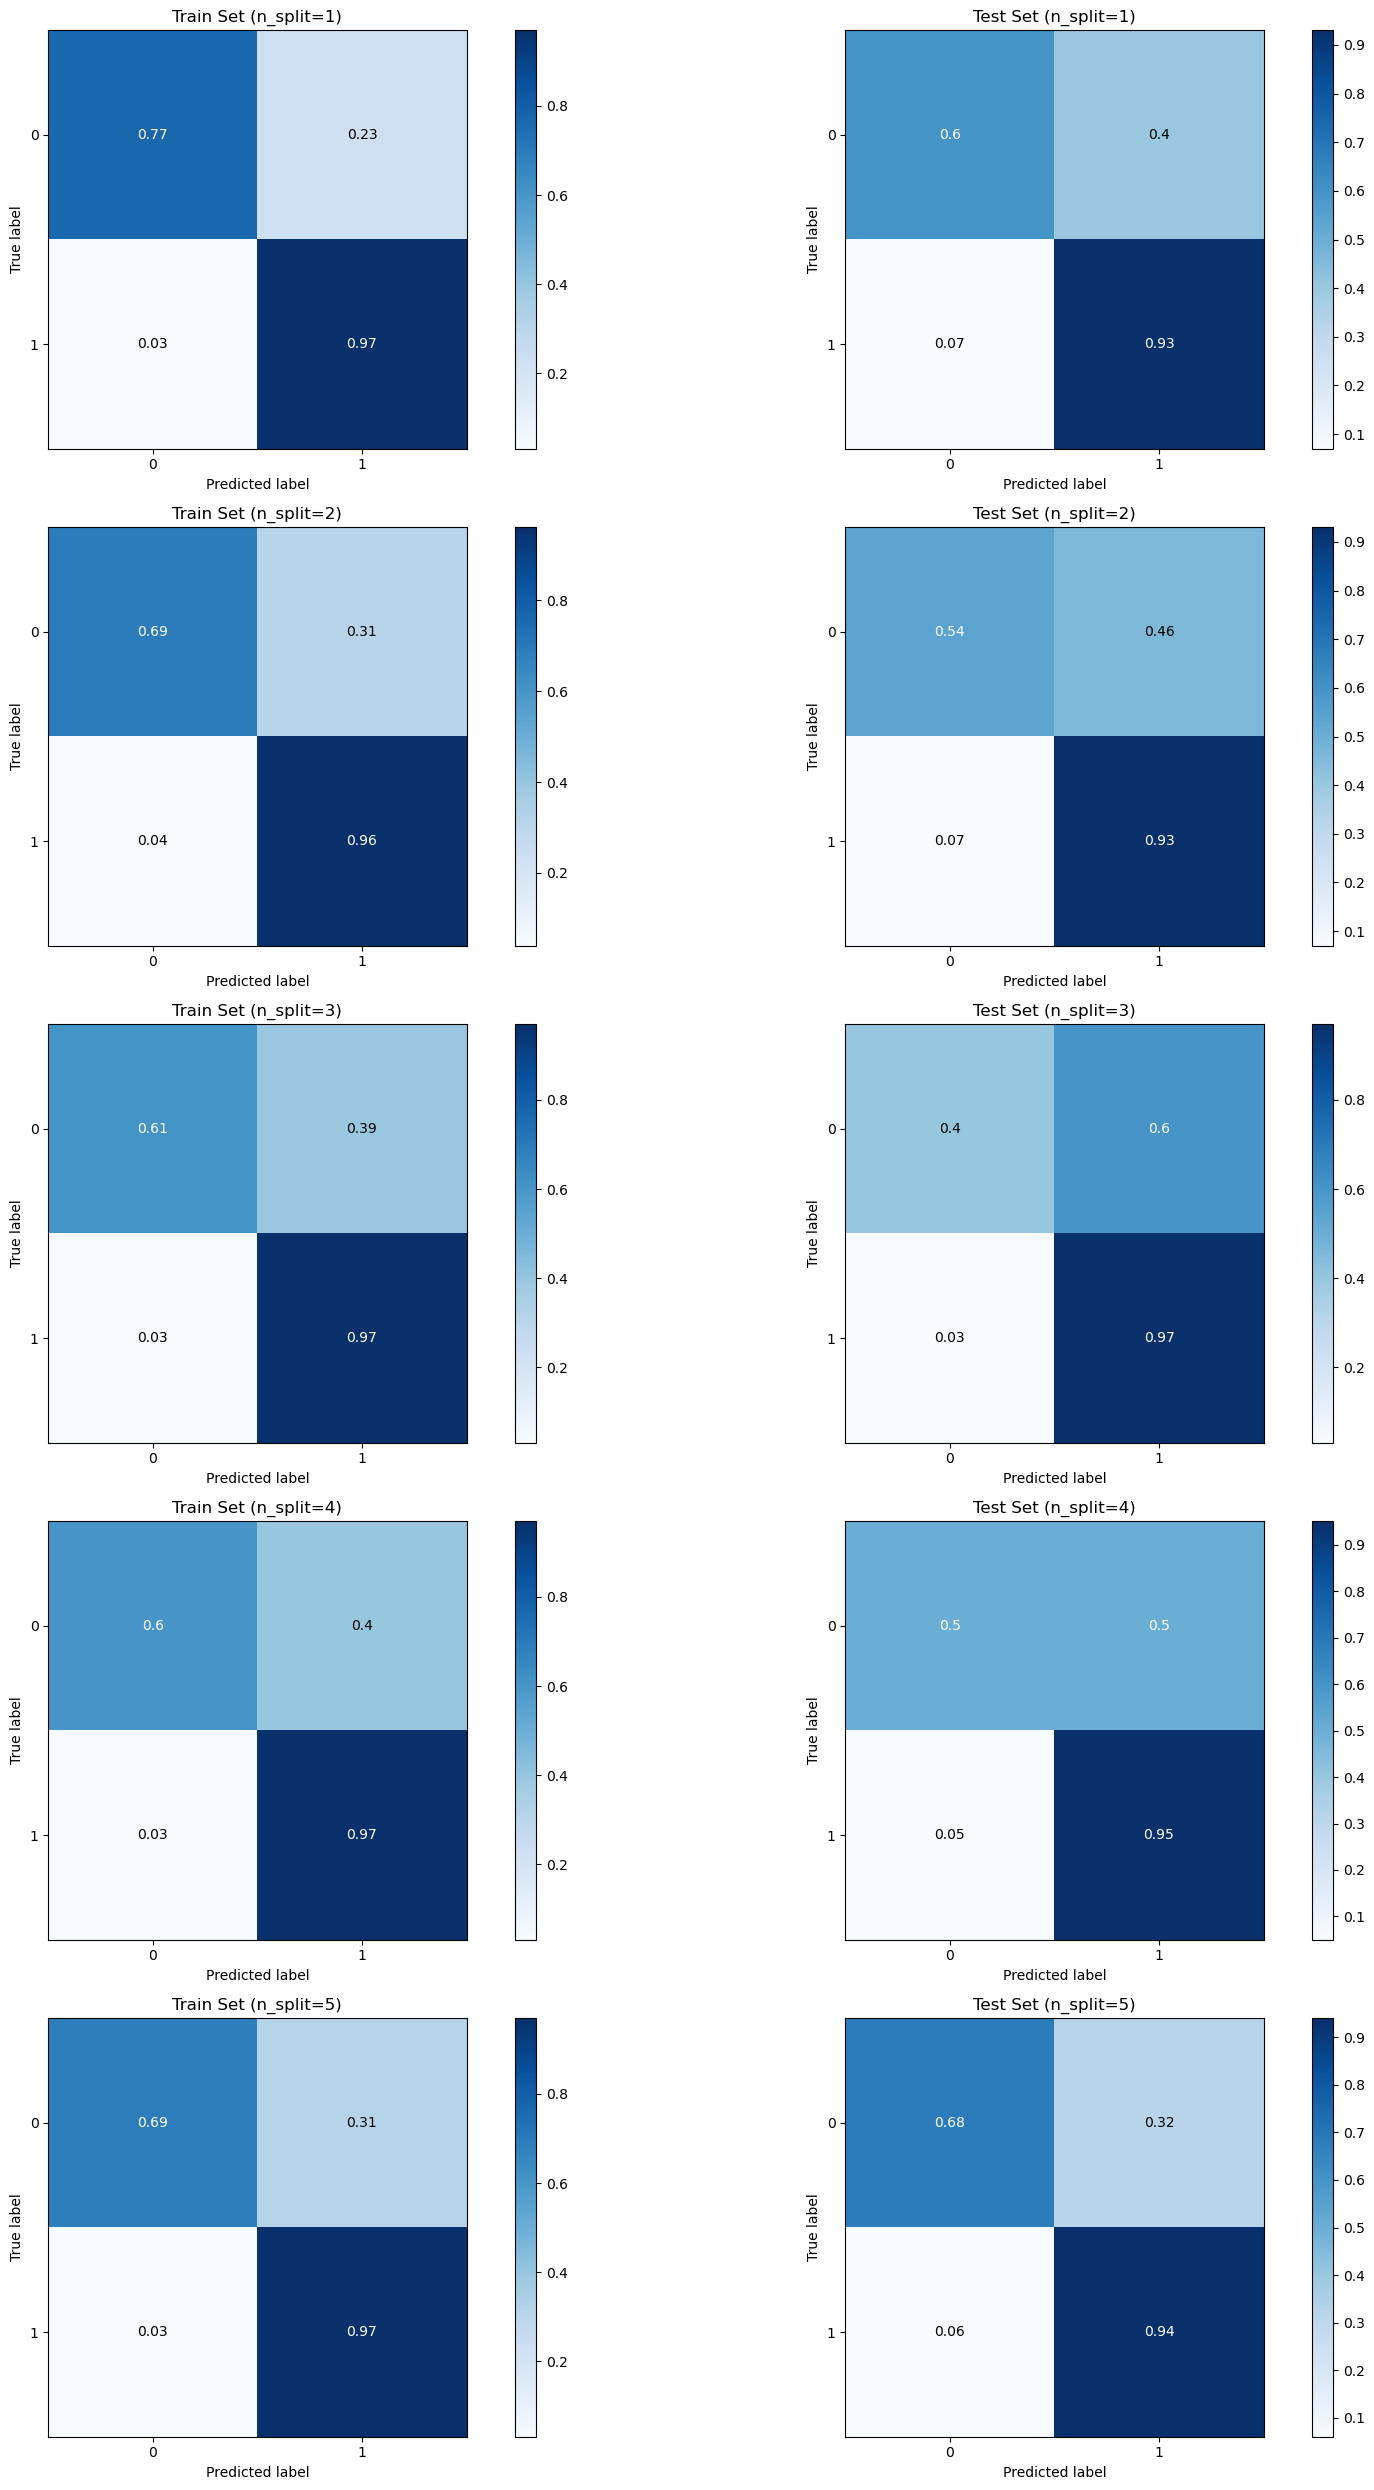

In [17]:
MyMultiTrainTester.plot_confusion(normalize=True)

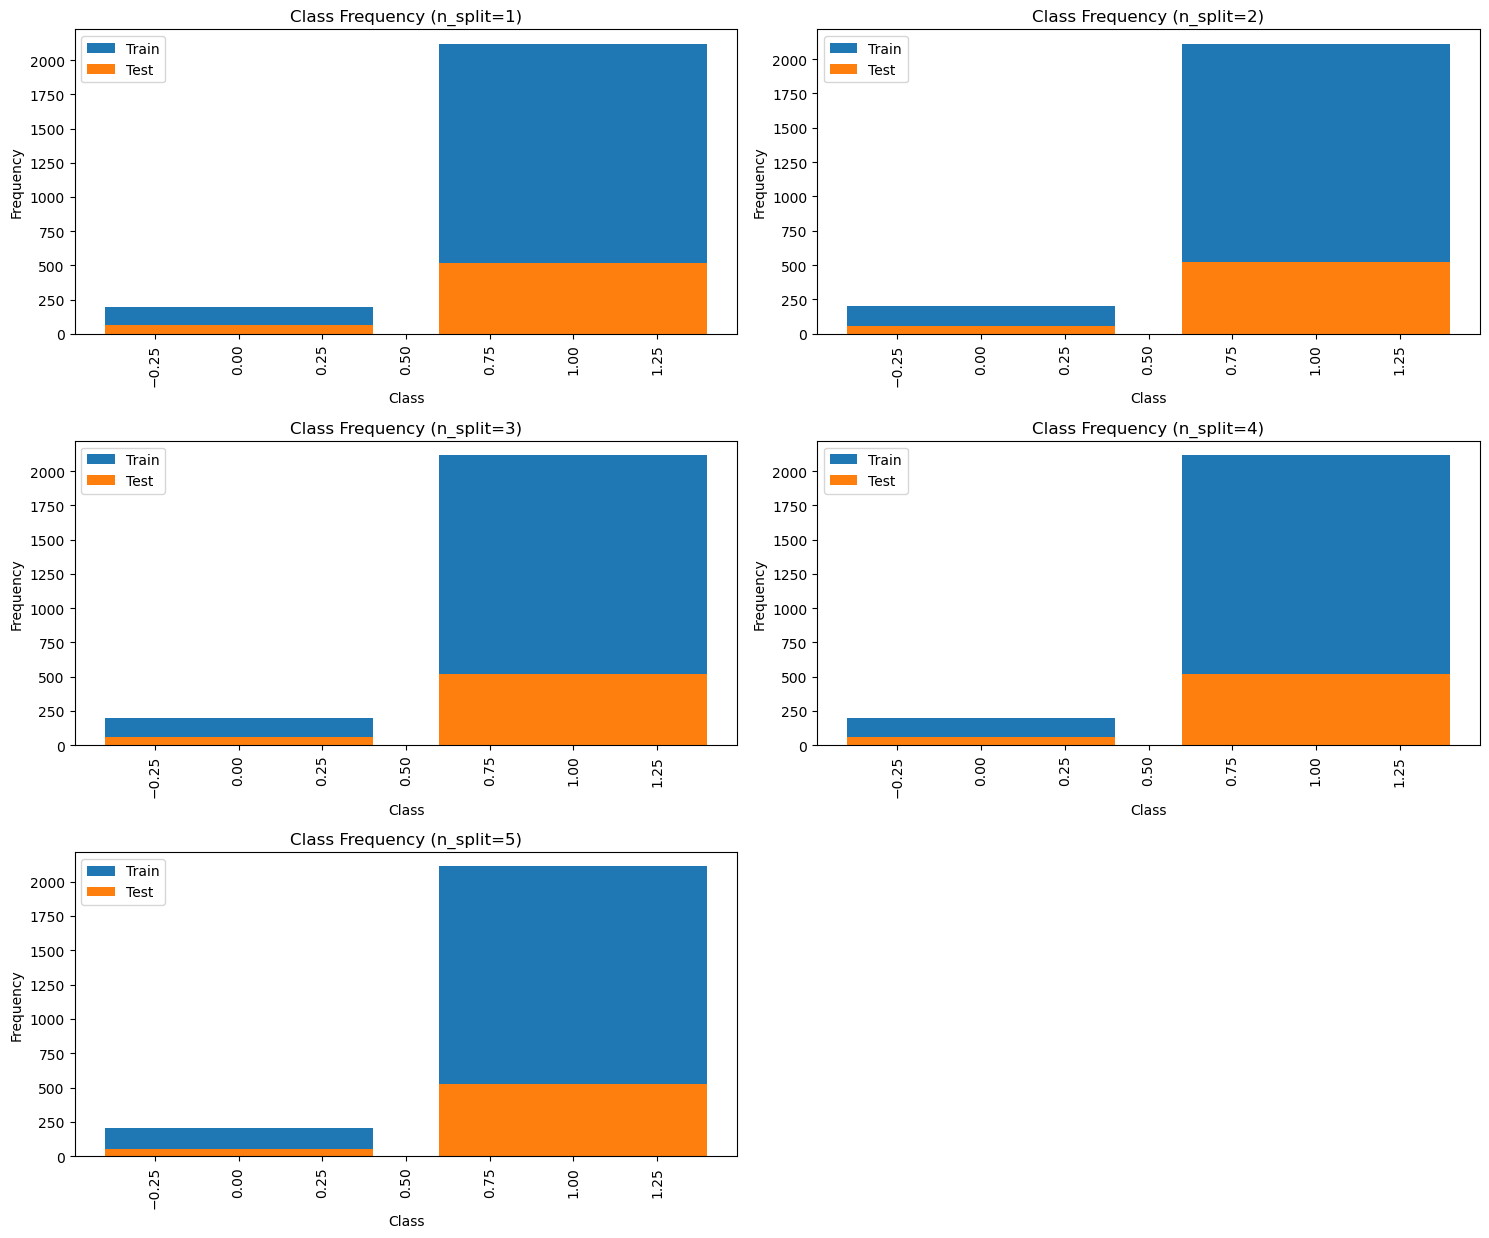

In [18]:
MyMultiTrainTester.plot_class_freq(normalize=True)

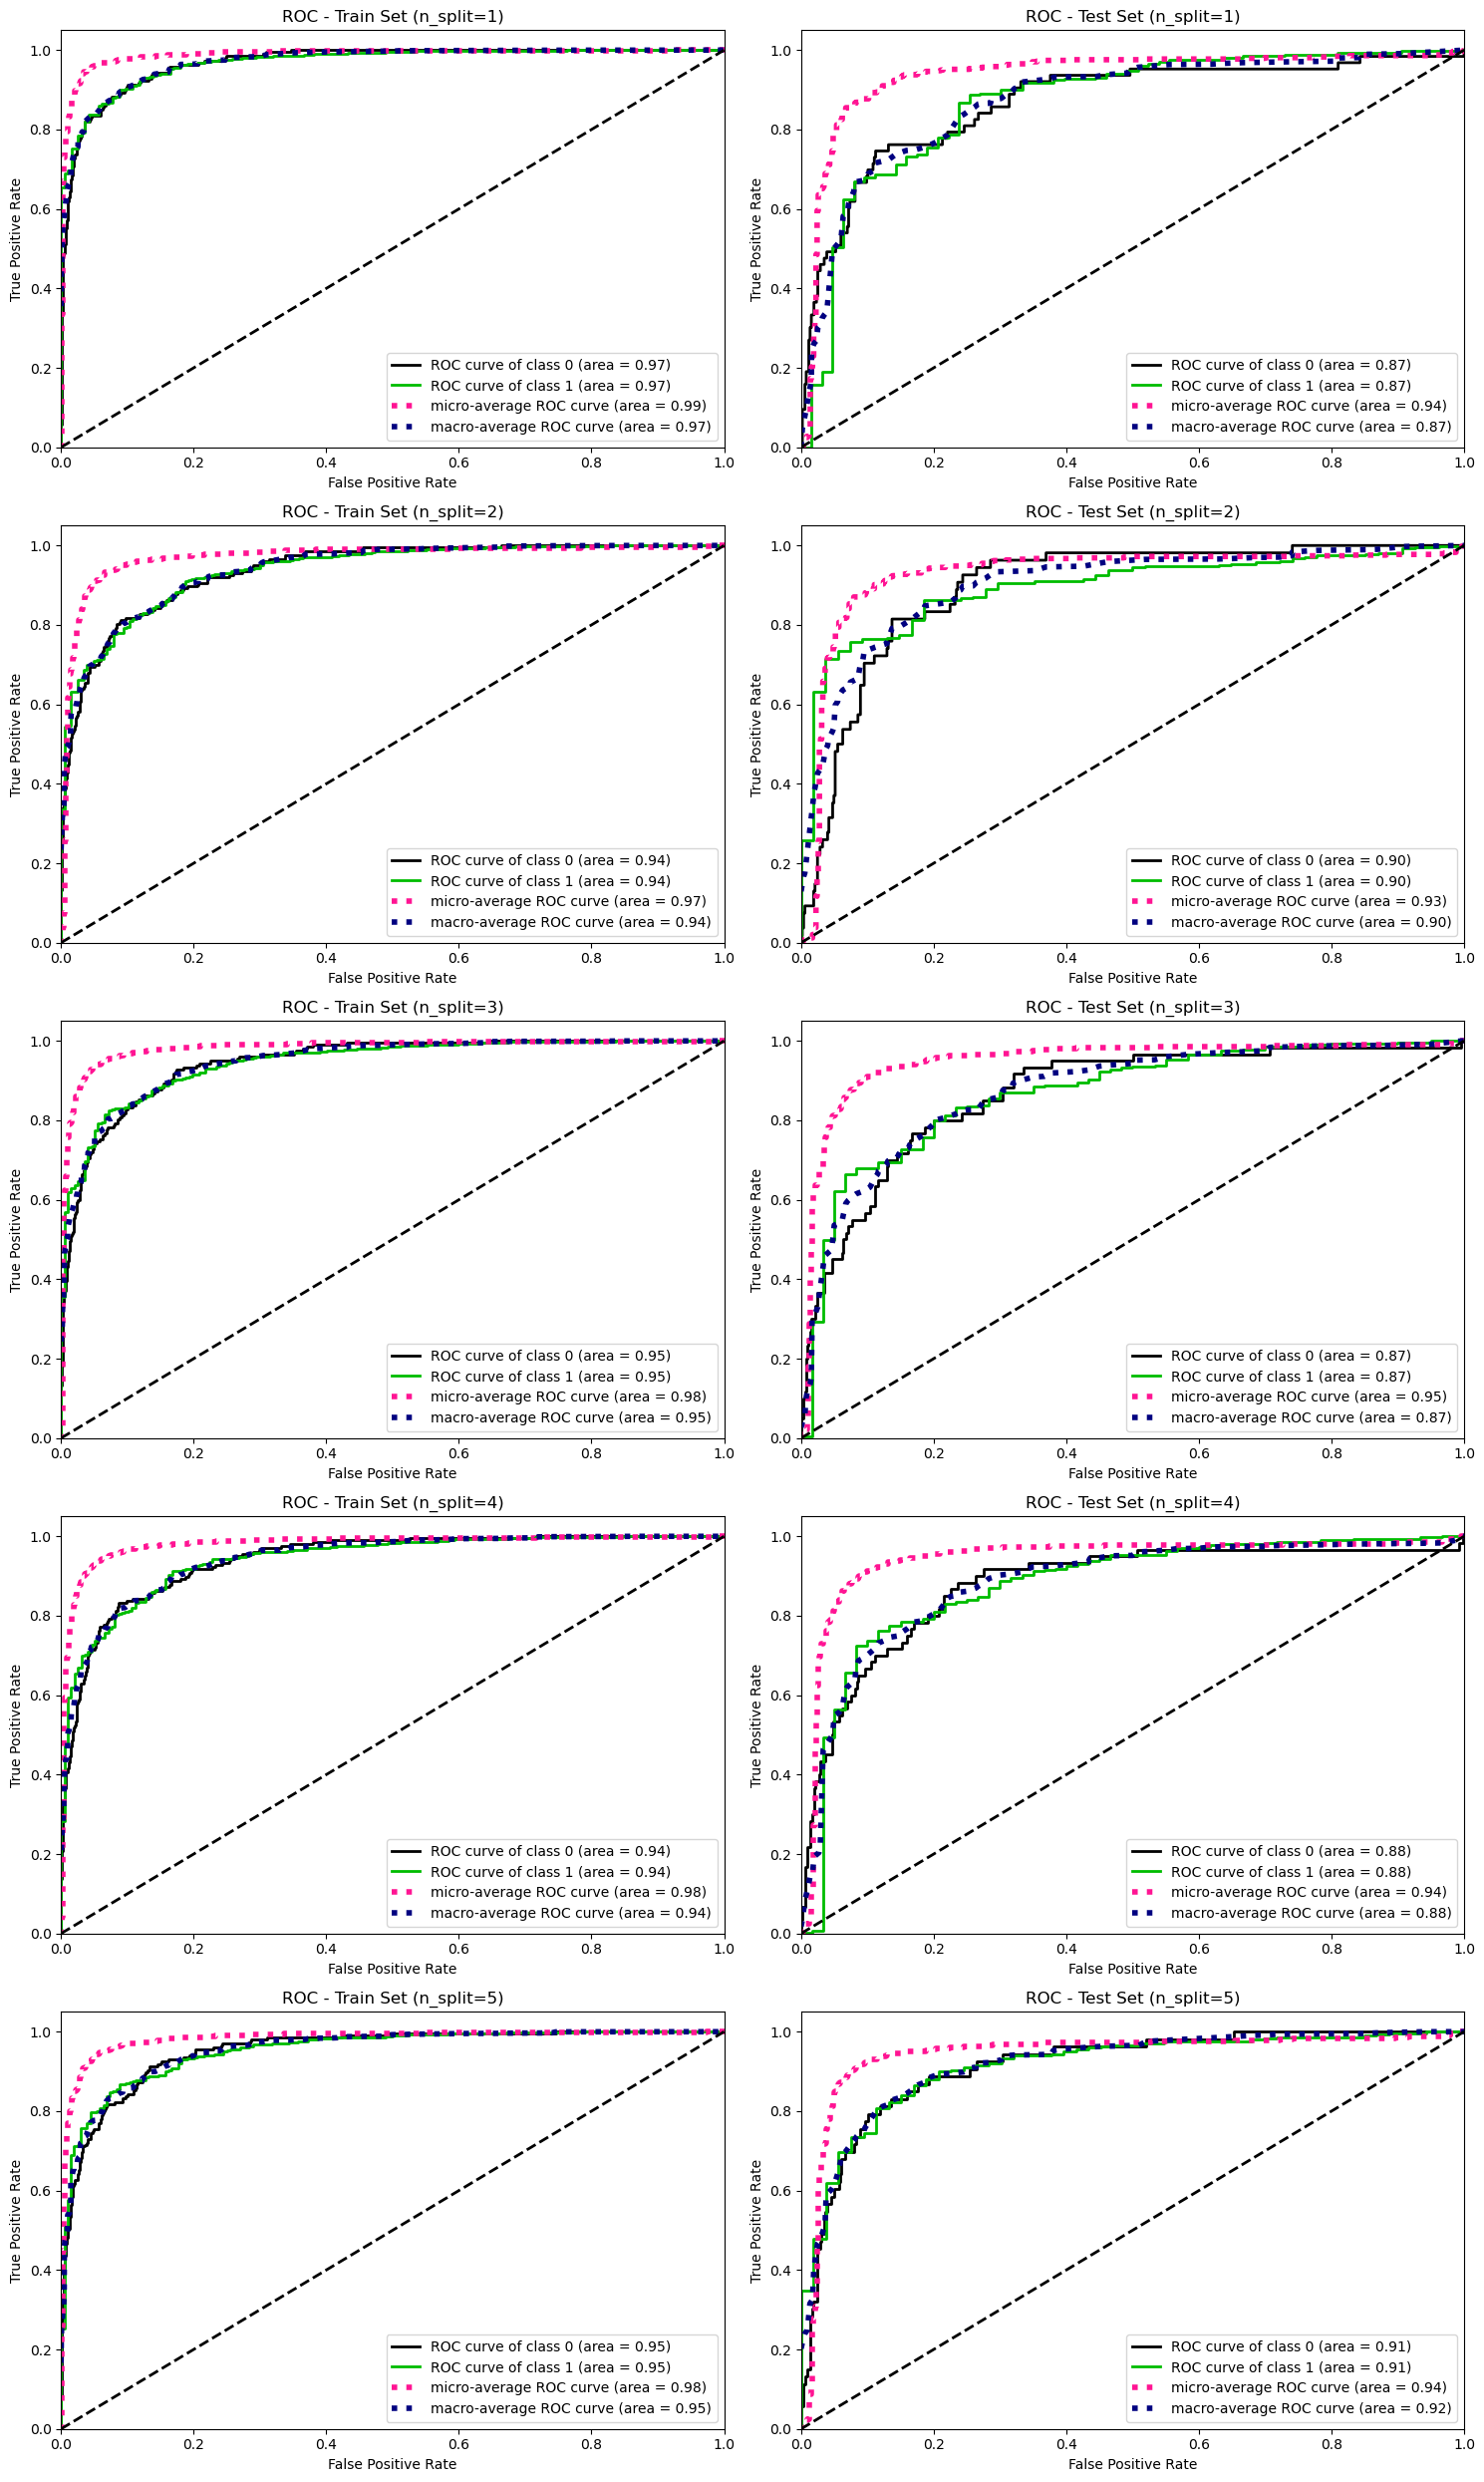

In [19]:
MyMultiTrainTester.plot_roc()

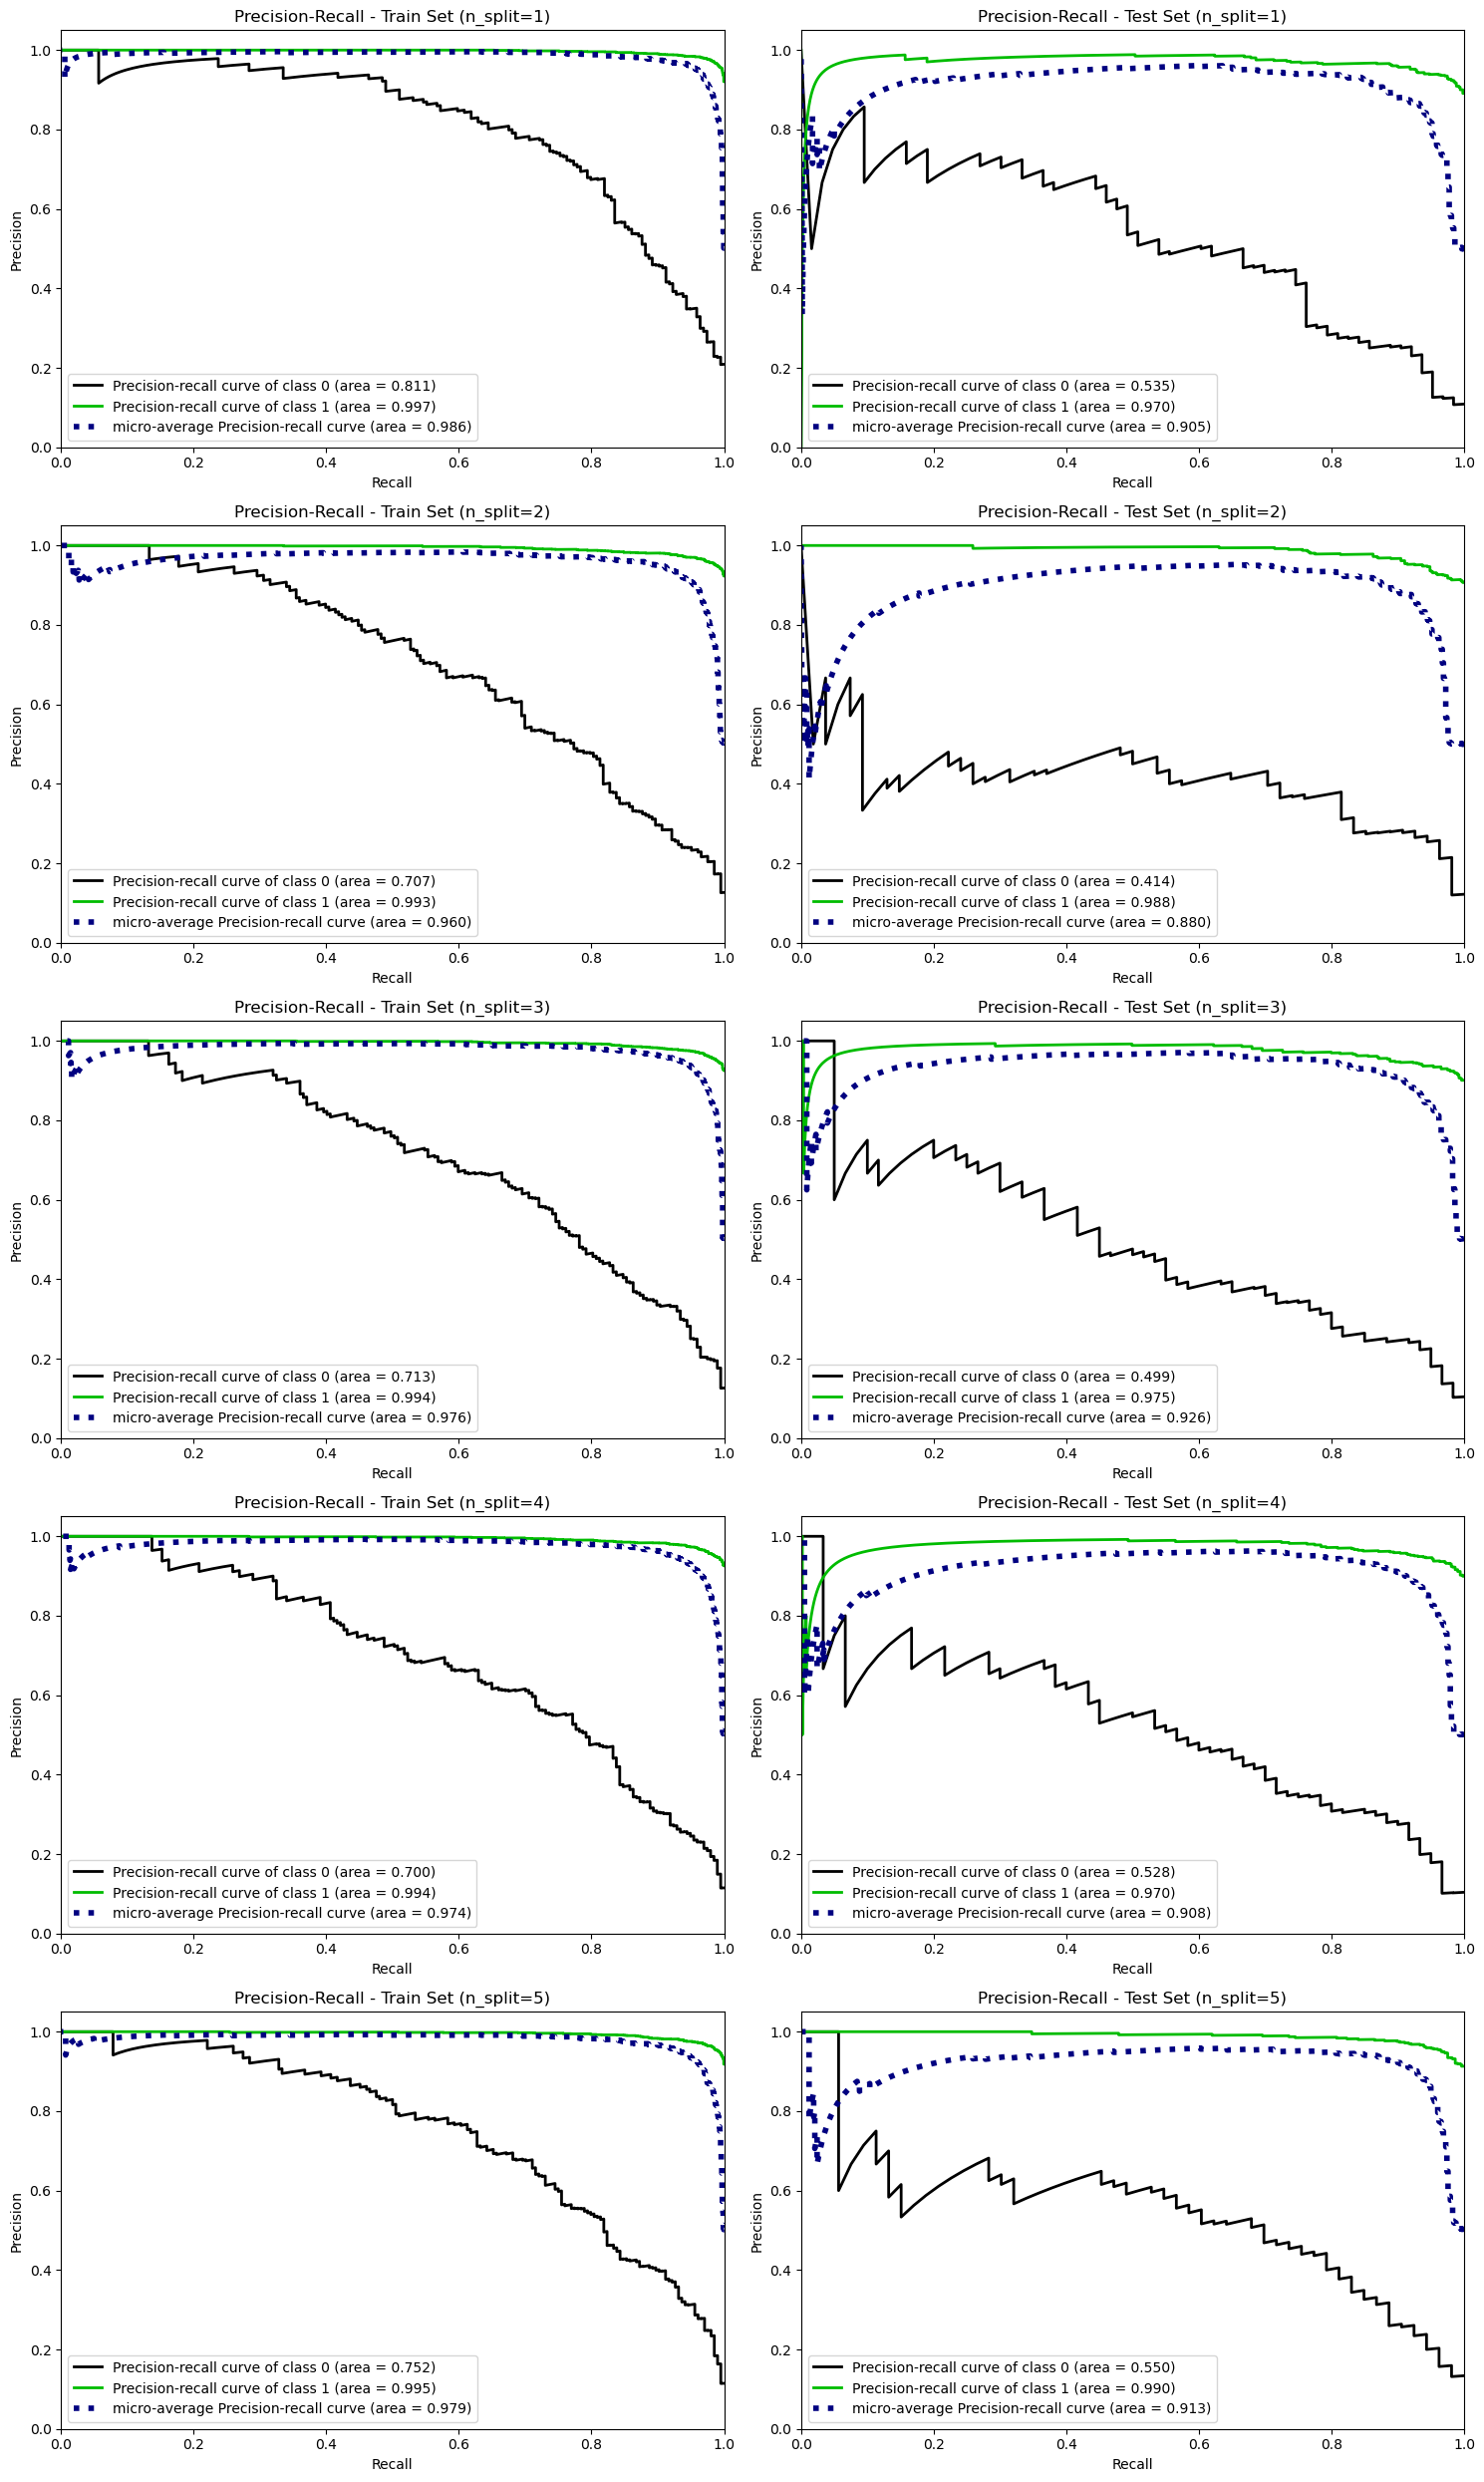

In [20]:
MyMultiTrainTester.plot_precrecall()